In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import wandb
import os
import torch.optim as optimizers
import pandas as pd
from copy import deepcopy
from ml_collections import ConfigDict 
import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from collections import defaultdict
import yaml
from sklearn.metrics import roc_auc_score
import numpy as np

import sys
sys.path.append("../../src")
import dfs_code 
from dfs_transformer import collate_downstream, DFSCodeSeq2SeqFC, Trainer
torch.multiprocessing.set_sharing_strategy('file_system')


2022-01-31 13:09:36.811939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt/lib:/opt/intel/tbb/lib:/opt/intel/clck/2019.0/lib:/opt/intel/compilers_and_libraries_2019/linux/lib:/opt/intel/compilers_and_libraries/linux/lib:/opt/intel/itac/2019.0.018/lib:/opt/intel/itac_2019/intel64/lib:/opt/intel/itac_latest/intel64/lib:/opt/intel/parallel_studio_xe_2019.0.045/clck_2019/lib:/opt/intel/parallel_studio_xe_2019.0.045/itac_2019/l

In [3]:
graph_file = "/mnt/ssd/datasets/graphs/reddit_threads/reddit_edges.json"
label_file = "/mnt/ssd/datasets/graphs/reddit_threads/reddit_target.csv"
batch_size = 1000

In [4]:
with open(graph_file, 'r') as f:
    graph_dict = json.load(f)
label_df = pd.read_csv(label_file)

In [5]:
label_df.head()

,id,target
0,0,0
1,1,1
2,2,0
3,3,1
4,4,0


In [6]:
label_df['target'].sum()/len(label_df)

0.5124133380603483

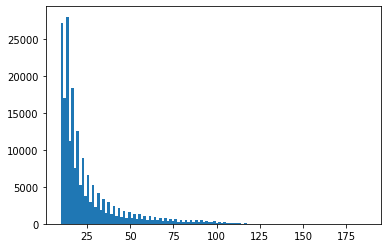

In [7]:
from matplotlib import pyplot as plt
n_edges = [len(graph) for graph in graph_dict.values()]
plt.hist(n_edges, bins='rice')
plt.show()

In [8]:
def graph2labelledgraph(graph):
    graph = deepcopy(graph)
    node_ids = np.unique(graph).tolist()
    dummy = max(node_ids) + 1
    
    edge_labels = len(graph)*[0]
    edgeindex = []
    for e in graph:
        edgeindex += [e]
        edgeindex += [[e[1], e[0]]]
        edge_labels += [0]
    
    edgeindex = np.asarray(edgeindex).T
    
    node_labels = []
    for idx in node_ids:
        node_labels += [(edgeindex[0] == idx).sum()]
    return edgeindex, node_labels, edge_labels

In [9]:
class KarateClubDataset(Dataset):
    def __init__(self, graph_file, label_file, max_n = None, max_edges=110):
        self.graph_file = graph_file
        self.label_file = label_file
        with open(graph_file, 'r') as f:
            self.graph_dict = json.load(f)
        self.label_df = pd.read_csv(label_file)
        self.data = []
        self.maxn = max_n
        self.max_edges = max_edges
        self.preprocess()
    
    def preprocess(self):
        maxn = self.maxn
        maxdegree = 0
        edgeindex_list = []
        vlabels_list = []
        elabels_list = []
        label_list = []
        for idx, (graph, label) in tqdm.tqdm(enumerate(zip(self.graph_dict.values(), self.label_df['target']))):  
            edgeindex, vlabels, elabels = graph2labelledgraph(graph)
            if len(elabels)//2 > self.max_edges:
                continue
            maxdegree = max(maxdegree, max(vlabels))
            edgeindex_list += [edgeindex]
            vlabels_list += [vlabels]
            elabels_list += [elabels]
            label_list += [self.label_df['target'][idx]]
            if maxn is not None:
                if idx >= maxn:
                    break
        self.maxdegree = maxdegree
        
        for idx, (edgeindex, vlabels, elabels, label) in tqdm.tqdm(enumerate(zip(edgeindex_list,
                                                                                vlabels_list,
                                                                                elabels_list, 
                                                                                label_list))):  
            node_features = F.one_hot(torch.tensor(vlabels), num_classes=maxdegree+1).float()
            edge_features = F.one_hot(torch.tensor(elabels), num_classes=2).float()
            code, index = dfs_code.rnd_dfs_code_from_edgeindex(edgeindex, vlabels, elabels)
            self.data += [ConfigDict({"node_labels":torch.tensor(vlabels),
                                    "edge_labels":torch.tensor(elabels),
                                    "edge_index":torch.tensor(edgeindex, dtype=torch.long),
                                    "min_dfs_code":torch.tensor(code),
                                    "min_dfs_index":torch.tensor(index, dtype=torch.long),
                                    "node_features":node_features,
                                    "edge_features":edge_features,
                                    "y": torch.tensor(label, dtype=torch.float32),
                                    "idx":idx})]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        

In [10]:
dataset = KarateClubDataset(graph_file, label_file, max_n=10000)

10000it [00:02, 4959.40it/s]
9976it [00:04, 2173.85it/s]


In [11]:
bins = np.arange(56)

In [12]:
data = next(iter(dataset))

In [13]:
np.histogram(data['node_labels'], bins=bins)[0]

array([0, 8, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
n = len(dataset)
n_train = int(0.8*n)
n_valid = 0
n_test = n - n_train - n_valid

perm = np.random.permutation(len(dataset))
train_idx = torch.tensor(perm[:n_train], dtype=torch.long)
valid_idx = torch.tensor(perm[n_train:n_train+n_valid].tolist(), dtype=torch.long)
test_idx = torch.tensor(perm[n_train+n_valid:].tolist(), dtype=torch.long)

In [15]:
ce = nn.BCEWithLogitsLoss() 

In [16]:
def collate_spectral(dlist, use_min=True):
    hists = []
    y_batch = []
    
    for d in dlist:
        A = np.zeros(2*[len(d.node_labels)])
        for e in d.edge_index.T:
            A[e[0], e[1]] = 1
        D = np.diag(d.node_labels)
        vals, vecs = np.linalg.eigh(D - A)
        indices = np.argsort(-np.abs(vals))[:10]
        feats = vecs[:, indices].mean(axis=0, keepdims=True)
        hists += [torch.tensor(feats, dtype=torch.float32)]
        y_batch += [d.y.unsqueeze(0).clone()]
        
    y = torch.cat(y_batch).unsqueeze(1)
    hist = torch.cat(hists, dim=0)

    return hist, y

def collate_degree_histogram(dlist, use_min=True):
    hists = []
    y_batch = []
    
    for d in dlist:
        hist_np = np.histogram(d.node_labels.clone().numpy(), bins=bins, density=True)[0][np.newaxis]
        hists += [torch.tensor(hist_np, dtype=torch.float32)]
        y_batch += [d.y.unsqueeze(0).clone()]
        
    y = torch.cat(y_batch).unsqueeze(1)
    hist = torch.cat(hists, dim=0)

    return hist, y

In [17]:
trainloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(train_idx), 
                         batch_size=batch_size, collate_fn=collate_degree_histogram, num_workers=8)
validloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(valid_idx), 
                         batch_size=batch_size, collate_fn=collate_degree_histogram, num_workers=8)
testloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(test_idx), 
                        batch_size=batch_size, collate_fn=collate_degree_histogram, num_workers=8)

In [18]:
data = next(iter(trainloader))

In [19]:
data[0]

tensor([[0.0000, 0.6364, 0.2727,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5263, 0.2456,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6875, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.6800, 0.1600,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6429, 0.2143,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.3529,  ..., 0.0000, 0.0000, 0.0000]])

In [20]:
model = nn.Sequential(nn.Linear(data[0].shape[1], 128), 
                      nn.ReLU(inplace=True), 
                      nn.Linear(128, 128),
                      nn.ReLU(inplace=True),
                      nn.Linear(128, 1))

In [21]:
data[0].shape

torch.Size([1000, 55])

In [22]:
def loss(pred, y, ce=ce):
    return ce(pred, y.float())

def auc(pred, y):
    return roc_auc_score(y.detach().cpu().numpy(), pred[:, 0].detach().cpu().numpy())
    

In [23]:
trainer = Trainer(model, trainloader, loss, metrics={'auc': auc}, lr=0.003, gpu_id=None, validloader=testloader, es_period=80)

In [ ]:
trainer.fit()

Epoch 28: loss 0.550705 0.7934: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.69it/s]


Epoch 30: loss 0.551366 0.7937: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.58it/s]


EarlyStopping counter: 1 out of 100


Epoch 50: loss 0.540836 0.8016: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.44it/s]


EarlyStopping counter: 1 out of 100


Epoch 70: loss 0.532874 0.8115: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.20it/s]


EarlyStopping counter: 1 out of 100


Epoch 98: loss 0.516586 0.8246: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.30it/s]


Epoch 110: loss 0.518723 0.8266: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.98it/s]


EarlyStopping counter: 1 out of 100


Epoch 130: loss 0.514620 0.8304: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.18it/s]


EarlyStopping counter: 1 out of 100


Epoch 150: loss 0.500236 0.8345: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.12it/s]


EarlyStopping counter: 1 out of 100


Epoch 170: loss 0.498210 0.8357: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.49it/s]


EarlyStopping counter: 1 out of 100


Epoch 180: loss 0.502341 0.8378: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.03it/s]


EarlyStopping counter: 2 out of 100


Epoch 190: loss 0.493824 0.8387: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.77it/s]


EarlyStopping counter: 3 out of 100


Epoch 200: loss 0.492837 0.8401: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


EarlyStopping counter: 4 out of 100


Epoch 220: loss 0.493844 0.8413: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


EarlyStopping counter: 1 out of 100


Epoch 230: loss 0.485574 0.8436: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.52it/s]


EarlyStopping counter: 2 out of 100


Epoch 240: loss 0.488814 0.8436: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


EarlyStopping counter: 3 out of 100


Epoch 250: loss 0.486133 0.8451: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


EarlyStopping counter: 4 out of 100


Epoch 260: loss 0.486958 0.8451: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.53it/s]


EarlyStopping counter: 5 out of 100


Epoch 270: loss 0.485189 0.8469: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


EarlyStopping counter: 6 out of 100


Epoch 280: loss 0.478208 0.8489: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.22it/s]


EarlyStopping counter: 7 out of 100


Epoch 290: loss 0.482047 0.8480: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.64it/s]


EarlyStopping counter: 8 out of 100


Epoch 300: loss 0.479386 0.8490: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


EarlyStopping counter: 9 out of 100


Epoch 310: loss 0.502866 0.8470: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.49it/s]


EarlyStopping counter: 10 out of 100


Epoch 320: loss 0.473298 0.8506: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.55it/s]


EarlyStopping counter: 11 out of 100


Epoch 330: loss 0.473495 0.8512: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.57it/s]


EarlyStopping counter: 12 out of 100


Epoch 340: loss 0.475864 0.8498: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.93it/s]


EarlyStopping counter: 13 out of 100


Epoch 350: loss 0.473846 0.8528: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.29it/s]


EarlyStopping counter: 14 out of 100


Epoch 360: loss 0.471858 0.8527: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.15it/s]


EarlyStopping counter: 15 out of 100


Epoch 370: loss 0.487083 0.8512: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.86it/s]


EarlyStopping counter: 16 out of 100


Epoch 380: loss 0.467994 0.8542: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.58it/s]


EarlyStopping counter: 17 out of 100


Epoch 390: loss 0.469659 0.8540: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.14it/s]


EarlyStopping counter: 18 out of 100


Epoch 400: loss 0.467194 0.8550: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.17it/s]


EarlyStopping counter: 19 out of 100


Epoch 410: loss 0.466388 0.8576: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.80it/s]


EarlyStopping counter: 20 out of 100


Epoch 420: loss 0.465179 0.8577: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.99it/s]


EarlyStopping counter: 21 out of 100


Epoch 430: loss 0.470718 0.8572: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.04it/s]


EarlyStopping counter: 22 out of 100


Epoch 440: loss 0.463723 0.8582: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


EarlyStopping counter: 23 out of 100


Epoch 450: loss 0.470212 0.8584: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


EarlyStopping counter: 24 out of 100


Epoch 460: loss 0.470058 0.8576: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


EarlyStopping counter: 25 out of 100


Epoch 470: loss 0.463213 0.8598: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.31it/s]


EarlyStopping counter: 26 out of 100


Epoch 480: loss 0.460937 0.8612: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.29it/s]


EarlyStopping counter: 27 out of 100


Epoch 490: loss 0.474464 0.8567: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.87it/s]


EarlyStopping counter: 28 out of 100


Epoch 500: loss 0.473281 0.8587: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.58it/s]


EarlyStopping counter: 29 out of 100


Epoch 510: loss 0.457406 0.8614: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.52it/s]


EarlyStopping counter: 30 out of 100


Epoch 520: loss 0.483285 0.8569: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.39it/s]


EarlyStopping counter: 31 out of 100


Epoch 530: loss 0.464591 0.8624: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.49it/s]


EarlyStopping counter: 32 out of 100


Epoch 540: loss 0.473002 0.8623: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.12it/s]


EarlyStopping counter: 33 out of 100


Epoch 550: loss 0.454068 0.8637: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.43it/s]


EarlyStopping counter: 34 out of 100


Epoch 560: loss 0.452508 0.8639: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


EarlyStopping counter: 35 out of 100


Epoch 570: loss 0.451539 0.8661: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.03it/s]


EarlyStopping counter: 36 out of 100


Epoch 580: loss 0.448334 0.8673: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


EarlyStopping counter: 37 out of 100


Epoch 590: loss 0.456293 0.8642: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.10it/s]


EarlyStopping counter: 38 out of 100


  0%|                                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]